In [1]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from scipy.stats import entropy
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)
import seaborn as sns

# DATA LOADING

In [2]:
data = []
labels = []
file_name = []
target_size = (256, 256)
for sub_folder in os.listdir("Dataset"):
    sub_folder_files = os.listdir(os.path.join("Dataset", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("Dataset", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        img = cv.resize(img, target_size)

        data.append(img)
        labels.append(sub_folder)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)



# Data Understanding

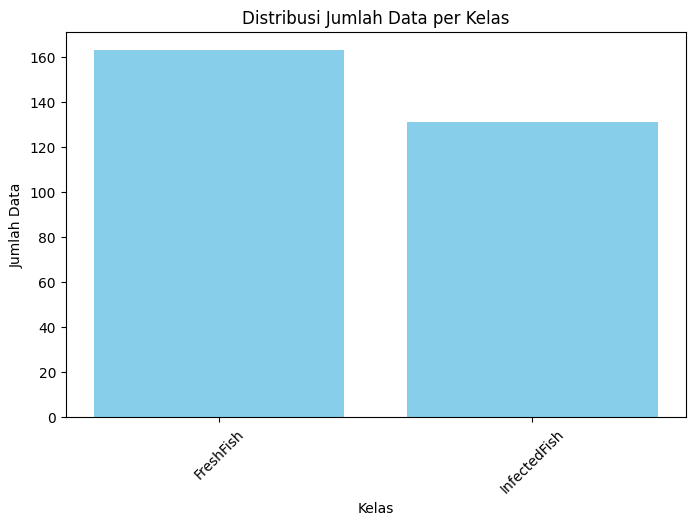

In [3]:
# Menampilkan jumlah data per kelas
unique_labels, counts = np.unique(labels, return_counts=True)
plt.figure(figsize=(8, 5))
plt.bar(unique_labels, counts, color='skyblue')
plt.xlabel("Kelas")
plt.ylabel("Jumlah Data")
plt.title("Distribusi Jumlah Data per Kelas")
plt.xticks(rotation=45)
plt.show()

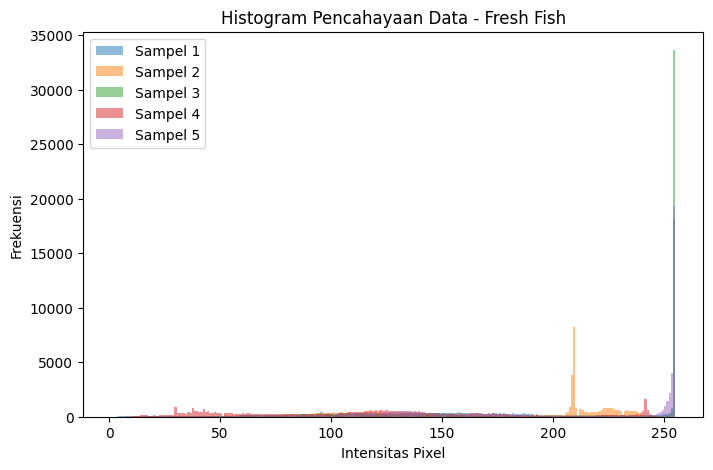

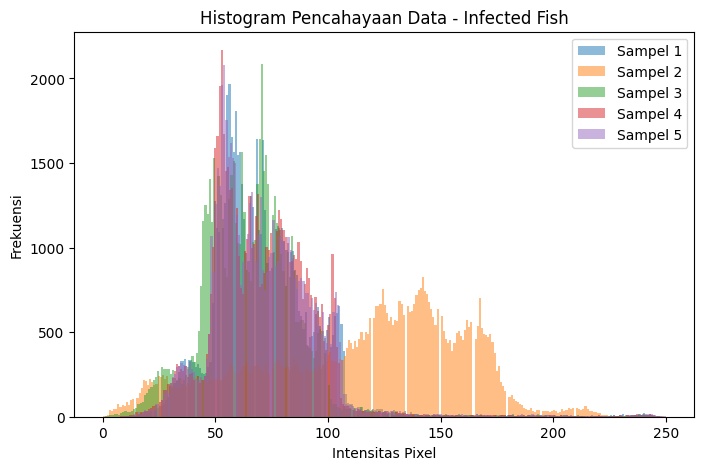

In [4]:
fresh_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "FreshFish"]
infected_fish_samples = [data[i] for i in range(len(labels)) if labels[i] == "InfectedFish"]

plt.figure(figsize=(8, 5))
for i in range(min(5, len(fresh_fish_samples))):
    img = fresh_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Fresh Fish")
plt.legend()
plt.show()

plt.figure(figsize=(8, 5))
for i in range(min(5, len(infected_fish_samples))):  
    img = infected_fish_samples[i]
    plt.hist(img.ravel(), bins=256, alpha=0.5, label=f'Sampel {i+1}')
plt.xlabel("Intensitas Pixel")
plt.ylabel("Frekuensi")
plt.title("Histogram Pencahayaan Data - Infected Fish")
plt.legend()
plt.show()

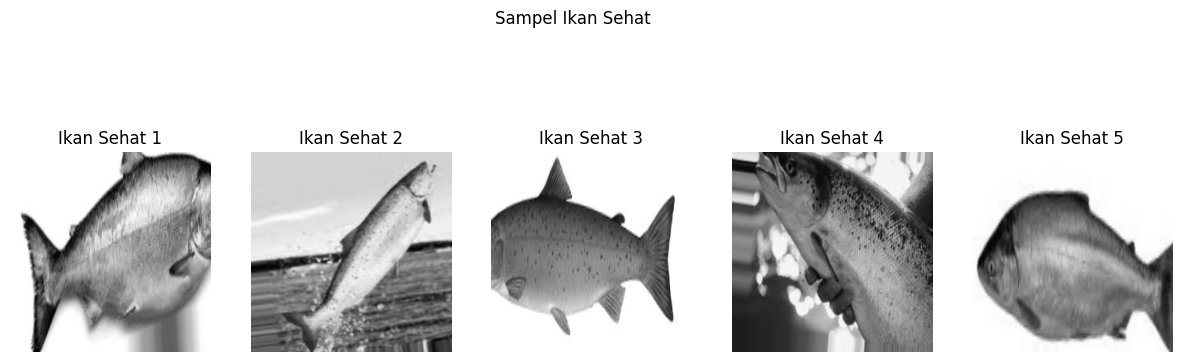

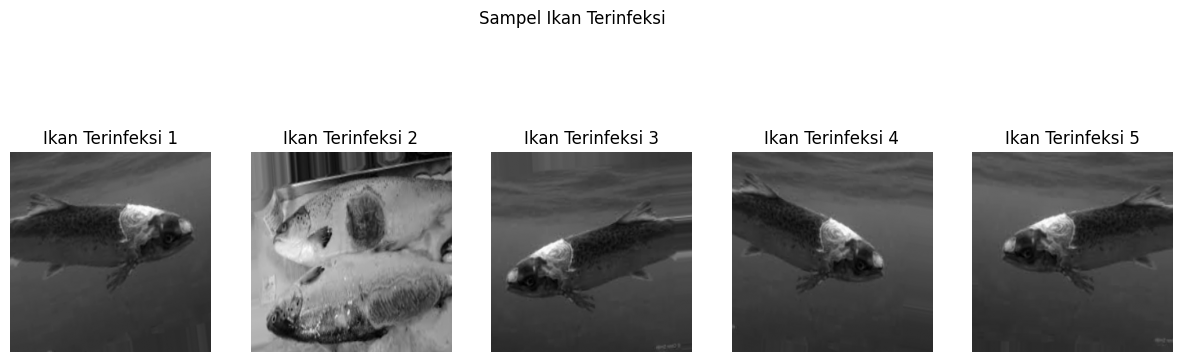

In [5]:
# Menampilkan sampel ikan sehat
fig, axes = plt.subplots(1, min(5, len(fresh_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(fresh_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(fresh_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Sehat {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Sehat")
plt.show()

fig, axes = plt.subplots(1, min(5, len(infected_fish_samples)), figsize=(15, 5))
for i in range(min(5, len(infected_fish_samples))):  # Menampilkan hingga 5 sampel
    axes[i].imshow(infected_fish_samples[i], cmap="gray")
    axes[i].set_title(f"Ikan Terinfeksi {i+1}")
    axes[i].axis("off")
plt.suptitle("Sampel Ikan Terinfeksi")
plt.show()

# Data Augmentation

In [6]:
augmented = {
    'data': [],
    'labels': [],
    'filenames': []
}

# Proses augmentasi
for i in range(len(data)):
    img = data[i]
    label = labels[i]
    filename = file_name[i]

    # 1. Flip Horizontal
    img_flip_h = cv.flip(img, 1)

    # 2. Flip Vertikal
    img_flip_v = cv.flip(img, 0)

    # 3. Rotasi 90 Derajat
    img_rot_90 = cv.rotate(img, cv.ROTATE_90_CLOCKWISE)

    # 4. Rotasi 180 Derajat
    img_rot_180 = cv.rotate(img, cv.ROTATE_180)

    # Simpan semua hasil ke dalam dictionary 'augmented'
    augmented_images = [
        (img_flip_h, 'flip_h'),
        (img_flip_v, 'flip_v'),
        (img_rot_90, 'rot_90'),
        (img_rot_180, 'rot_180'),
    ]

    for img_aug, suffix in augmented_images:
        augmented['data'].append(img_aug)
        augmented['labels'].append(label)
        augmented['filenames'].append(f"{filename}_{suffix}")

# Tampilkan hasil
print("Jumlah data sebelum augmentasi:", len(data))
print("Jumlah data setelah augmentasi:", len(augmented['data']))

Jumlah data sebelum augmentasi: 294
Jumlah data setelah augmentasi: 1176


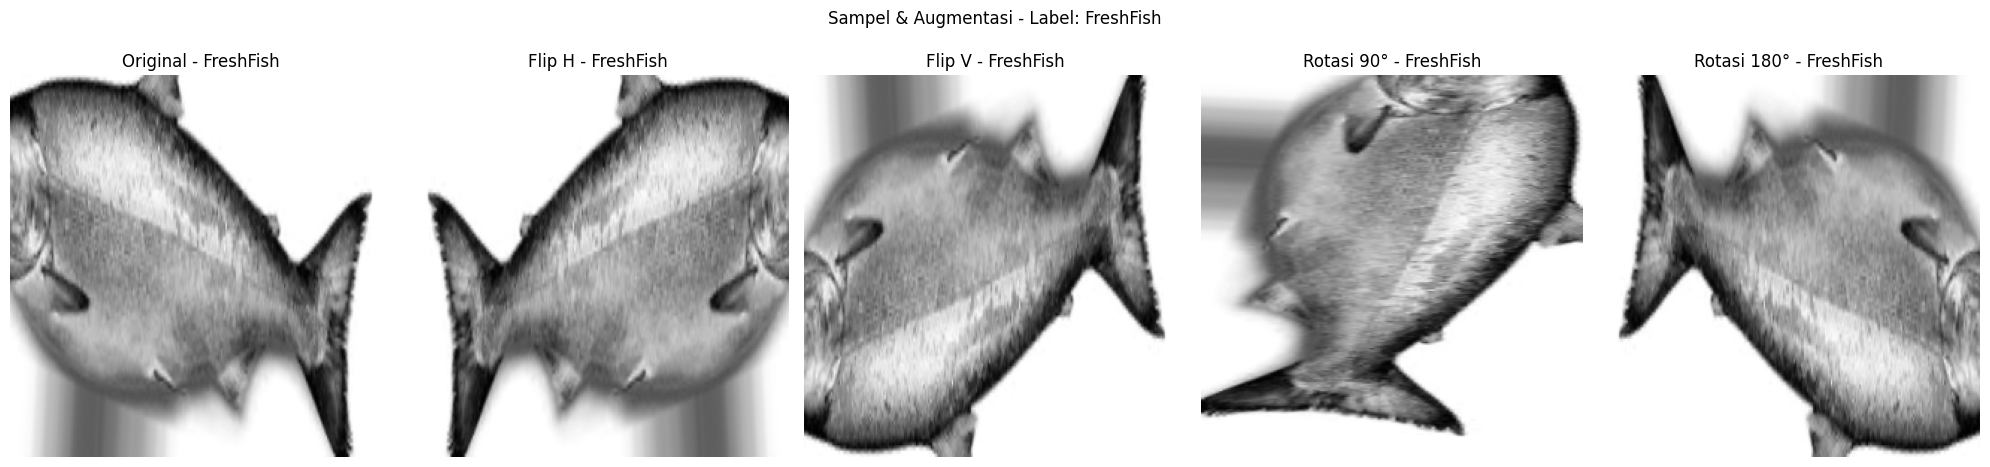

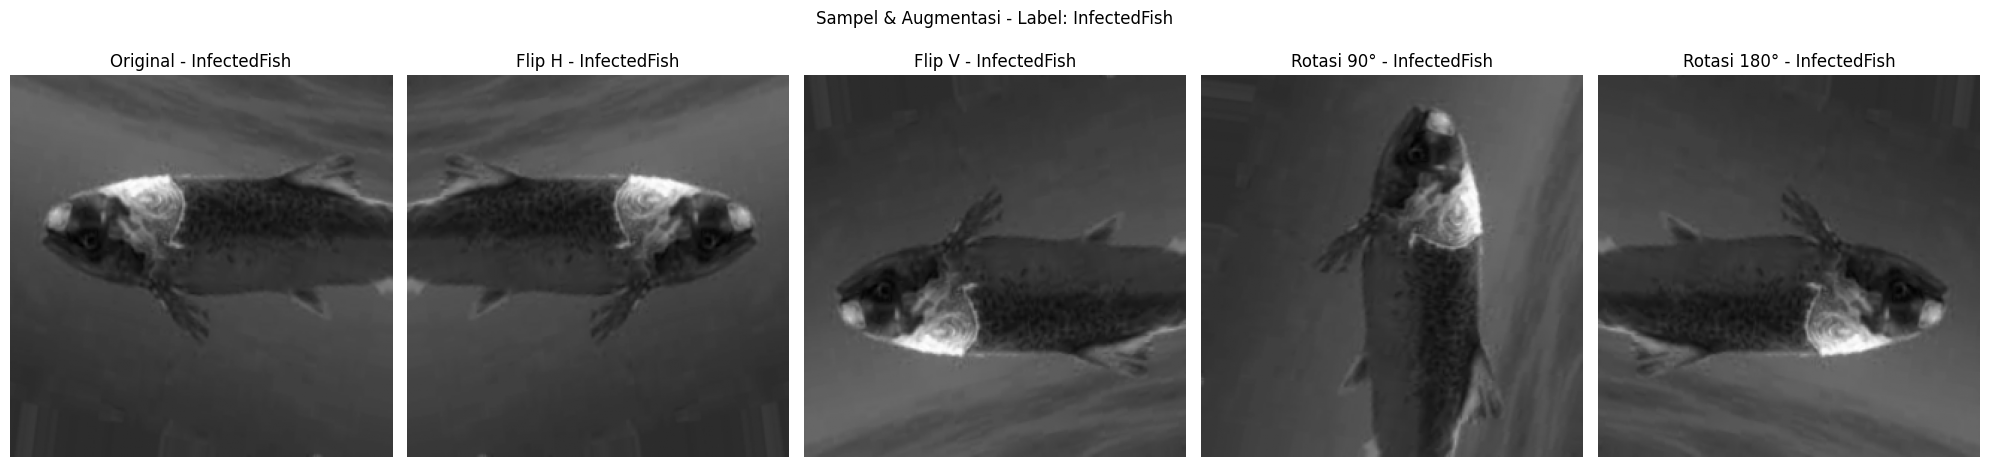

In [7]:
# Ambil label unik dari data yang telah di-augmentasi
unique_labels = np.unique(augmented['labels'])

for label in unique_labels:
    # Ambil semua gambar yang label-nya sama
    samples = [augmented['data'][i] for i in range(len(augmented['labels'])) if augmented['labels'][i] == label]

    if len(samples) > 0:
        sample_img = samples[0]  # Ambil satu contoh gambar

        # Siapkan tampilan
        fig, axes = plt.subplots(1, 5, figsize=(20, 5))
        augment_titles = ["Original", "Flip H", "Flip V", "Rotasi 90°", "Rotasi 180°"]

        # Daftar gambar hasil augmentasi tanpa translasi
        augmentations = [
            sample_img,
            cv.flip(sample_img, 1),
            cv.flip(sample_img, 0),
            cv.rotate(sample_img, cv.ROTATE_90_CLOCKWISE),
            cv.rotate(sample_img, cv.ROTATE_180)
        ]

        # Tampilkan semua hasil dalam satu baris
        for i in range(5):
            axes[i].imshow(augmentations[i], cmap="gray")
            axes[i].set_title(f"{augment_titles[i]} - {label}")
            axes[i].axis("off")

        plt.suptitle(f"Sampel & Augmentasi - Label: {label}")
        plt.tight_layout()
        plt.show()


# Preprocessing

In [8]:
def normalize(img):
    img = img.astype(np.float32)
    min_val = np.min(img)
    max_val = np.max(img)
    if max_val - min_val == 0:
        return np.zeros_like(img, dtype=np.uint8)
    norm_img = (img - min_val) / (max_val - min_val) * 255
    return norm_img.astype(np.uint8)

def histogram_equalization(img):
    # Histogram Equalization secara manual
    hist, bins = np.histogram(img.flatten(), 256, [0,256])
    cdf = hist.cumsum()
    cdf_masked = np.ma.masked_equal(cdf, 0)
    cdf_min = cdf_masked.min()
    cdf_max = cdf_masked.max()
    cdf_masked = (cdf_masked - cdf_min) * 255 / (cdf_max - cdf_min)
    cdf_final = np.ma.filled(cdf_masked, 0).astype('uint8')
    img_eq = cdf_final[img]
    return img_eq

def mean_filter(img, ksize=3):
    # Padding image
    pad = ksize // 2
    padded_img = np.pad(img, pad, mode='reflect')
    output = np.zeros_like(img, dtype=np.float32)
    for i in range(img.shape[0]):
        for j in range(img.shape[1]):
            region = padded_img[i:i+ksize, j:j+ksize]
            output[i, j] = np.mean(region)
    return output.astype(np.uint8)

def median_filter(img, ksize=3):
        # Padding image
        pad = ksize // 2
        padded_img = np.pad(img, pad, mode='reflect')
        output = np.zeros_like(img, dtype=np.float32)
        for i in range(img.shape[0]):
            for j in range(img.shape[1]):
                region = padded_img[i:i+ksize, j:j+ksize]
                output[i, j] = np.median(region)
        return output.astype(np.uint8)


In [9]:
# Percobaan 2: + Mean + Median filter
def prepro2(img):
    mean = mean_filter(img)
    median = median_filter(mean)
    eq = histogram_equalization(median)
    norm = normalize(eq)
    return norm

In [10]:
# Inisialisasi list untuk menyimpan hasil preprocessing
dataPreprocessed_2 = []

# Ambil data hasil augmentasi
augmented_data = augmented['data']

# Lakukan preprocessing untuk masing-masing percobaan
for img in augmented_data:
    dataPreprocessed_2.append(prepro2(img))
dataPreprocessed = dataPreprocessed_2

# Feature Extraction

In [11]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    # mengembalikan matrix glcm dari image
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [12]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [13]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [14]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [15]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [16]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [17]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [18]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [19]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(dataPreprocessed)):
    D0 = glcm(dataPreprocessed[i], 0)
    D45 = glcm(dataPreprocessed[i], 45)
    D90 = glcm(dataPreprocessed[i], 90)
    D135 = glcm(dataPreprocessed[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [20]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []

In [21]:
for i in range(len(dataPreprocessed)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [22]:
for i in range(len(dataPreprocessed)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [23]:
for i in range(len(dataPreprocessed)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [24]:
for i in range(len(dataPreprocessed)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [25]:
for i in range(len(dataPreprocessed)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [26]:
for i in range(len(dataPreprocessed)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [27]:
for i in range(len(dataPreprocessed)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

# Extract to CSV

In [28]:
dataTable = {'Filename': augmented['filenames'], 'Label': augmented['labels'],
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_2.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_2.csv')
hasilEkstrak

,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,aug_0_1014.png_flip_h,FreshFish,118.493045,148.262284,67.725934,178.264468,0.498097,0.473314,0.532077,0.434914,...,0.063924,0.061302,0.249978,0.248152,0.252831,0.247593,0.991662,0.989553,0.995237,0.987439
1,aug_0_1014.png_flip_v,FreshFish,118.493045,148.262284,67.725934,178.264468,0.498097,0.473314,0.532077,0.434914,...,0.063924,0.061302,0.249978,0.248152,0.252831,0.247593,0.991662,0.989553,0.995237,0.987439
2,aug_0_1014.png_rot_90,FreshFish,67.725934,148.262284,118.493045,178.264468,0.532077,0.473314,0.498097,0.434914,...,0.062489,0.061302,0.252831,0.248152,0.249978,0.247593,0.995237,0.989553,0.991662,0.987439
3,aug_0_1014.png_rot_180,FreshFish,118.493045,178.264468,67.725934,148.262284,0.498097,0.434914,0.532077,0.473314,...,0.063924,0.061580,0.249978,0.247593,0.252831,0.248152,0.991662,0.987439,0.995237,0.989553
4,aug_0_1086.png_flip_h,FreshFish,88.322748,142.111434,138.541682,251.346943,0.514028,0.430356,0.424978,0.371875,...,0.013735,0.012719,0.125044,0.116549,0.117198,0.112779,0.992173,0.987415,0.987738,0.977741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1171,aug_0_9830.png_rot_180,InfectedFish,86.160417,152.306867,80.631771,161.990788,0.390361,0.321661,0.354160,0.292485,...,0.001272,0.000953,0.037723,0.032439,0.035658,0.030863,0.992107,0.986059,0.992620,0.985173
1172,aug_0_9876.png_flip_h,InfectedFish,46.617662,151.928858,93.948744,98.747559,0.522456,0.431191,0.493019,0.467402,...,0.017391,0.017191,0.133681,0.126691,0.131876,0.131113,0.996049,0.987095,0.992046,0.991612
1173,aug_0_9876.png_flip_v,InfectedFish,46.617662,151.928858,93.948744,98.747559,0.522456,0.431191,0.493019,0.467402,...,0.017391,0.017191,0.133681,0.126691,0.131876,0.131113,0.996049,0.987095,0.992046,0.991612
1174,aug_0_9876.png_rot_90,InfectedFish,93.948744,151.928858,46.617662,98.747559,0.493019,0.431191,0.522456,0.467402,...,0.017871,0.017191,0.131876,0.126691,0.133681,0.131113,0.992046,0.987095,0.996049,0.991612


<Axes: >

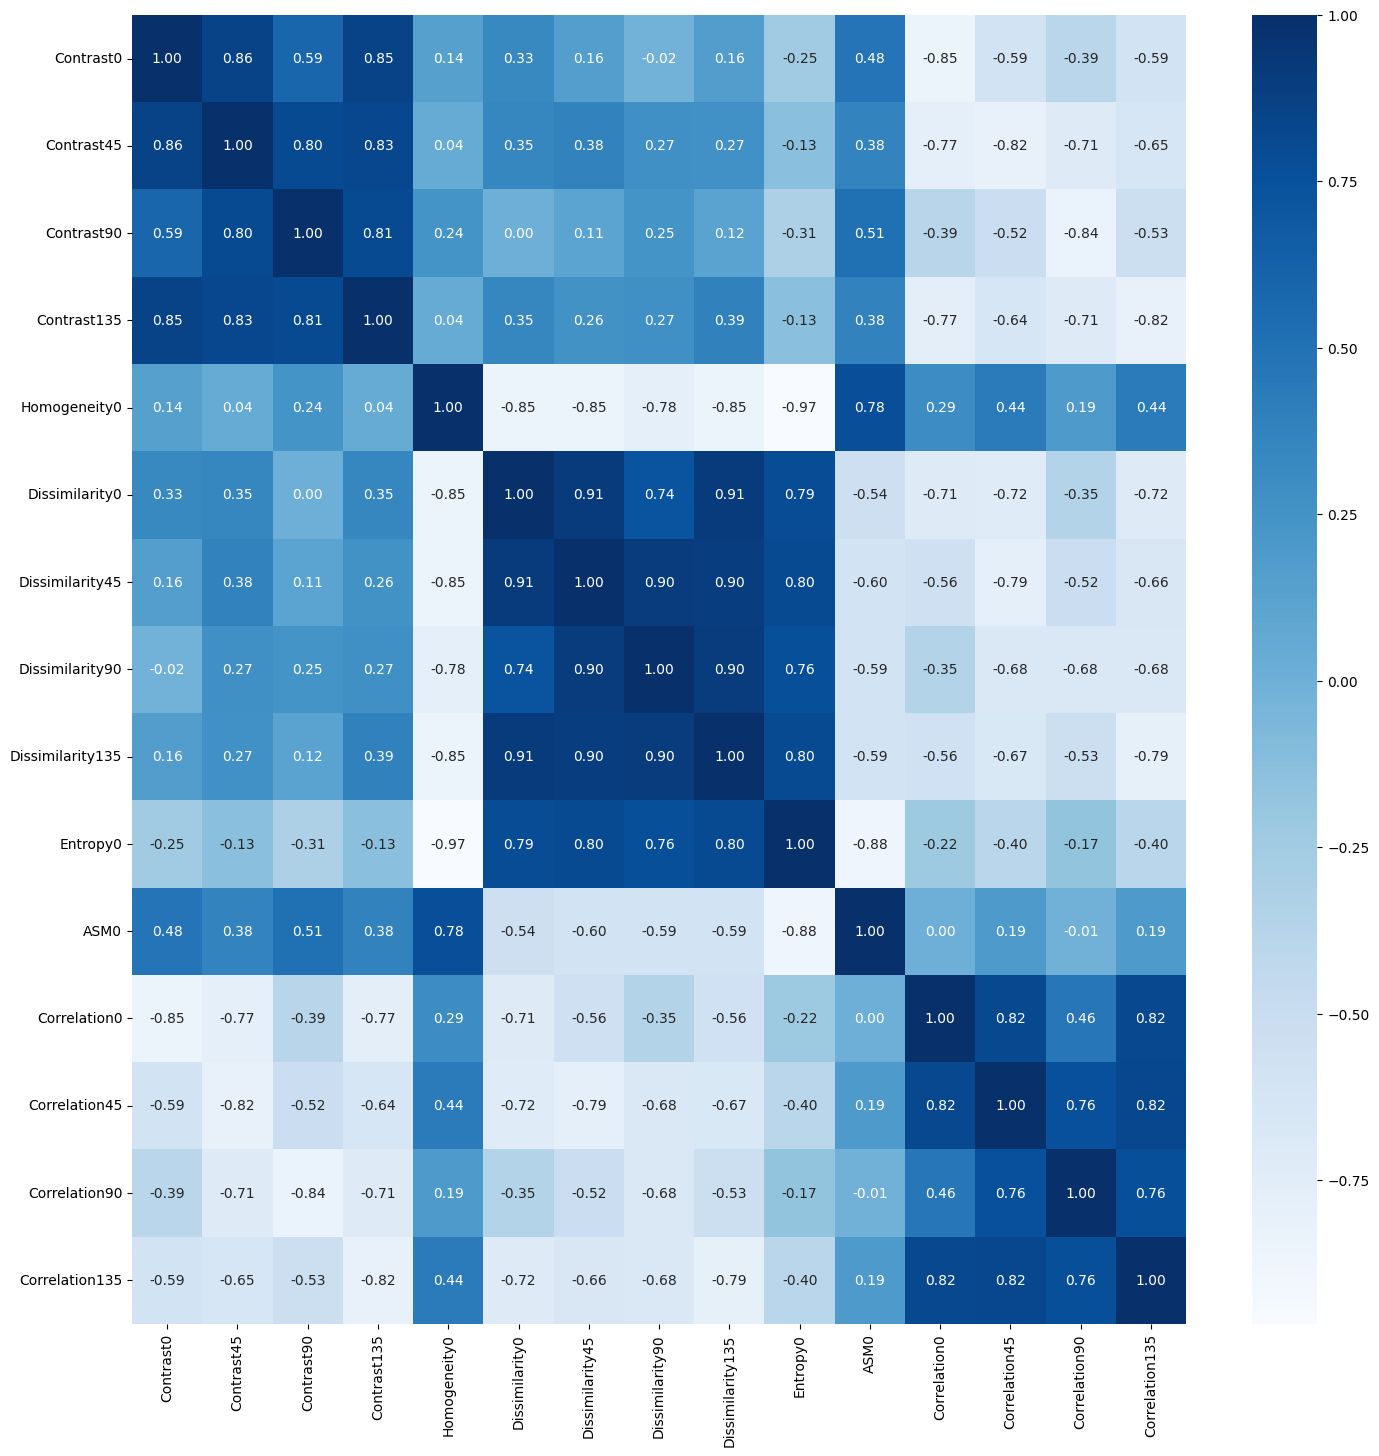

In [29]:
# Menghitung korelasi
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

# Menyaring fitur yang memiliki korelasi absolut lebih dari 0.95 dengan label
threshold = 0.95 # atur threshold ini untuk menentukan seberapa besar korelasi yang ingin disaring
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

# Splitting Data

In [37]:
# ubah bagian test_size sesuai kebutuhan
# 0.3 = 30% data untuk testing (train/test 70/30)
# 0.2 = 20% data untuk testing (train/test 80/20)
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.2, random_state=42)
print(X_train.shape)
print(X_test.shape)

(940, 15)
(236, 15)


# Feature Normalization

In [38]:
# normalisasi mean std
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

# Modeling Define Model

In [39]:
def generateClassificationReport(y_true, y_pred):
	print(classification_report(y_true, y_pred))
	print(confusion_matrix(y_true, y_pred))
	print('Accuracy:', accuracy_score(y_true, y_pred))

# Define classifiers
rf = RandomForestClassifier(n_estimators=5, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
knn = KNeighborsClassifier(n_neighbors=5)

# Train Random Forest Classifier

In [40]:
# Train Random Forest Classifier
rf.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("------Training Set------")
y_pred = rf.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = rf.predict(X_test)
generateClassificationReport( y_test, y_pred)

------Training Set------
              precision    recall  f1-score   support

   FreshFish       1.00      1.00      1.00       522
InfectedFish       1.00      1.00      1.00       418

    accuracy                           1.00       940
   macro avg       1.00      1.00      1.00       940
weighted avg       1.00      1.00      1.00       940

[[520   2]
 [  1 417]]
Accuracy: 0.9968085106382979

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.97      0.95      0.96       130
InfectedFish       0.94      0.96      0.95       106

    accuracy                           0.95       236
   macro avg       0.95      0.95      0.95       236
weighted avg       0.95      0.95      0.95       236

[[123   7]
 [  4 102]]
Accuracy: 0.9533898305084746


# Train SVM Classifier

In [41]:
# Train SVM Classifier
svm.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = svm.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = svm.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.90      0.90      0.90       522
InfectedFish       0.88      0.87      0.88       418

    accuracy                           0.89       940
   macro avg       0.89      0.89      0.89       940
weighted avg       0.89      0.89      0.89       940

[[472  50]
 [ 54 364]]
Accuracy: 0.8893617021276595

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.92      0.92      0.92       130
InfectedFish       0.90      0.90      0.90       106

    accuracy                           0.91       236
   macro avg       0.91      0.91      0.91       236
weighted avg       0.91      0.91      0.91       236

[[120  10]
 [ 11  95]]
Accuracy: 0.9110169491525424


# Train KNN Classifier

In [42]:
# Train KNN Classifier
knn.fit(X_train, y_train)

# Make predictions and evaluate the model with the training set
print("\n------Training Set------")
y_pred = knn.predict(X_train)
generateClassificationReport( y_train, y_pred)

# Make predictions and evaluate the model with the testing set
print("\n------Testing Set------")
y_pred = knn.predict(X_test)
generateClassificationReport( y_test, y_pred)


------Training Set------
              precision    recall  f1-score   support

   FreshFish       0.98      0.99      0.98       522
InfectedFish       0.98      0.98      0.98       418

    accuracy                           0.98       940
   macro avg       0.98      0.98      0.98       940
weighted avg       0.98      0.98      0.98       940

[[515   7]
 [ 10 408]]
Accuracy: 0.9819148936170212

------Testing Set------
              precision    recall  f1-score   support

   FreshFish       0.98      0.98      0.98       130
InfectedFish       0.97      0.97      0.97       106

    accuracy                           0.97       236
   macro avg       0.97      0.97      0.97       236
weighted avg       0.97      0.97      0.97       236

[[127   3]
 [  3 103]]
Accuracy: 0.9745762711864406


# Evaluation With Confusion Matrix

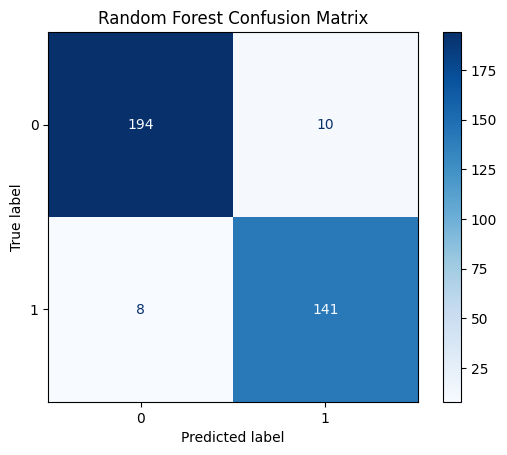

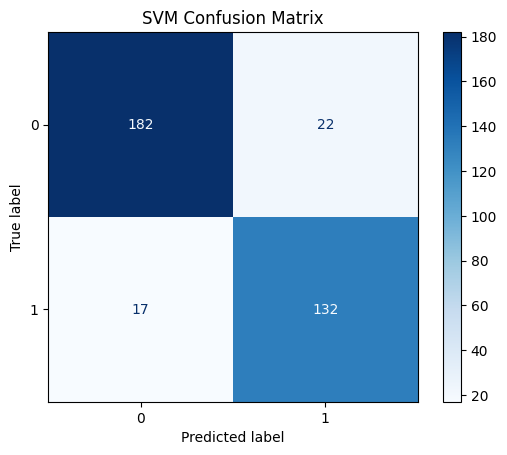

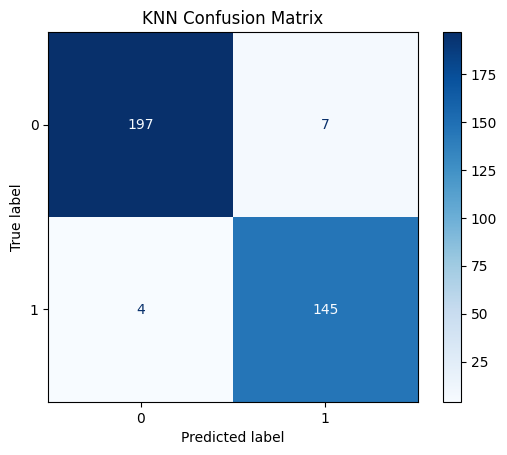

In [36]:
def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

# Plot confusion matrix for Random Forest
plot_confusion_matrix(y_test, rf.predict(X_test), "Random Forest Confusion Matrix")
# Plot confusion matrix for SVM
plot_confusion_matrix(y_test, svm.predict(X_test), "SVM Confusion Matrix")
# Plot confusion matrix for KNN
plot_confusion_matrix(y_test, knn.predict(X_test), "KNN Confusion Matrix")